# Homework 3

First example with Tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'4'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
  return onehot

## 1. Data Set
Load `genomics_ood`

In [ ]:
# Load train and test data as subsets (first 10%, last 1%) of the shuffled data set genomics_ood
train_dataset, test_dataset = tfds.load("genomics_ood", split=['train[:10%]', 'test[-1%:]'], as_supervised= True, shuffle_files=True)
assert isinstance(train_dataset, tf.data.Dataset)

# Onehotify of seq and labels (each data point contains 'seq' for the genom sequence and a corresponding label)
train_dataset = train_dataset.map(lambda seq,label: (onehotify(seq),tf.one_hot(label, 10)))
test_dataset = test_dataset.map(lambda seq,label: (onehotify(seq),tf.one_hot(label, 10)))

# Batching and fetching
# Another shuffle (buffer_size should be greater equal data set size)
train_dataset = train_dataset.shuffle(buffer_size=100000).batch(100).prefetch(1)
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(10).prefetch(1)

## 2. Model

We use a fully connected feed forward neural network with two hidden layers, each with 256 units and sigmoid activation function and an output layer of size 10 with softmax activation function.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Two hidden layers
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        # Output Layer
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

## 3. Training
Train with SGD for 10 epochs with a learning rate of 0.1, while the loss is categorical cross entropy.

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=100000)
    test_dataset = test_dataset.shuffle(buffer_size=1000)

    #training (and checking in with training)
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
    train_losses.append(train_loss)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


## 4. Visualization
Visualize both accuracy and loss for training and test data

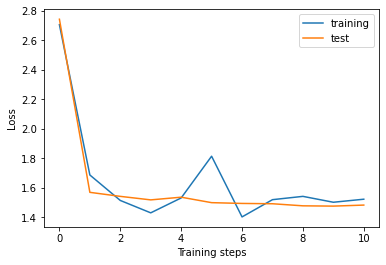

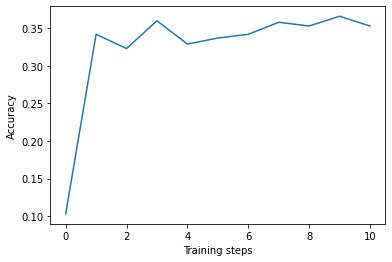

In [ ]:
%matplotlib inline

# Loss (in one plot)
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Accuracy
plt.figure()
plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
for acc in test_accuracies:
  print(acc)

0.10300000000000001
0.342
0.32299999999999995
0.36
0.32900000000000007
0.33699999999999997
0.342
0.3579999999999999
0.35300000000000004
0.3660000000000001
0.353
